In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow_hub as hub

In [2]:
BatchSize = 32
ImageSize = 256

In [3]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/train",
    image_size=(ImageSize, ImageSize),
    batch_size=BatchSize,
    shuffle=True,
)

Found 2746 files belonging to 5 classes.


In [4]:
class_names = image_dataset.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [5]:
# Save class names
import json
class_names = image_dataset.class_names
with open("dataset/class_names.json", "w") as f:
    json.dump(class_names, f)

In [6]:
for image_batch, labels_batch in image_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 4 3 3 1 1 0 1 1 3 2 1 0 0 2 0 2 3 0 4 2 3 1 2 3 1 3 0 3 3 1]


In [7]:
for image_batch, labels_batch in image_dataset.take(1):
    print(image_batch[0].numpy())

[[[6.18750000e+01 6.28750000e+01 5.48750000e+01]
  [6.06250000e+01 6.16250000e+01 5.36250000e+01]
  [5.93750000e+01 6.03750000e+01 5.23750000e+01]
  ...
  [2.85805664e+01 2.95805664e+01 2.45805664e+01]
  [2.73476562e+01 2.83476562e+01 2.33476562e+01]
  [2.69726562e+01 2.79726562e+01 2.29726562e+01]]

 [[6.18750000e+01 6.28750000e+01 5.48750000e+01]
  [6.06250000e+01 6.16250000e+01 5.36250000e+01]
  [5.93750000e+01 6.03750000e+01 5.23750000e+01]
  ...
  [2.70000000e+01 2.80000000e+01 2.30000000e+01]
  [2.63750000e+01 2.73750000e+01 2.23750000e+01]
  [2.60000000e+01 2.70000000e+01 2.20000000e+01]]

 [[6.17382812e+01 6.27382812e+01 5.47382812e+01]
  [6.04882812e+01 6.14882812e+01 5.34882812e+01]
  [5.92382812e+01 6.02382812e+01 5.22382812e+01]
  ...
  [2.71367188e+01 2.81367188e+01 2.31367188e+01]
  [2.65117188e+01 2.75117188e+01 2.25117188e+01]
  [2.60170898e+01 2.70170898e+01 2.20170898e+01]]

 ...

 [[1.95654785e+02 1.75928223e+02 1.13280762e+02]
  [1.96785156e+02 1.77007324e+02 1.1602

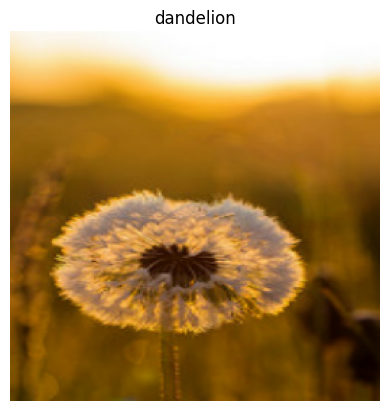

In [8]:
for image_batch, labels_batch in image_dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    plt.axis("off")

In [9]:
def get_dataset_partitions(image_dataset, train_split=0.8, val_split=0.1):

    ds_size = len(image_dataset)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = image_dataset.take(train_size)
    temp_ds = image_dataset.skip(train_size)
    val_ds = temp_ds.take(val_size)
    
    
    return train_ds, val_ds

In [10]:
train_ds, val_ds = get_dataset_partitions(image_dataset)

In [11]:
len(train_ds), len(val_ds)

(68, 8)

In [12]:
folder_path = "dataset/test"
image_list = []
for fname in os.listdir(folder_path):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(folder_path, fname)
        img = load_img(img_path, target_size=(ImageSize, ImageSize))
        img_array = img_to_array(img)
        image_list.append(img_array)

# Convert list to NumPy array for prediction
test_ds = np.array(image_list)

In [13]:
test_ds = test_ds / 255.0  # Normalize the images

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(ImageSize, ImageSize),
    layers.Rescaling(1.0/255)
])

In [45]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)

])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [54]:
input_shape = (ImageSize, ImageSize, 3)

cnn_model_v4 = tf.keras.Sequential([

    resize_and_rescale,
    data_augmentation,
    
        #cnn:
        layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(0.005), input_shape = input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(filters = 256, kernel_size = (3,3), padding= 'same', activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(filters = 256, kernel_size = (3,3), padding= 'same', activation = 'relu'),
        layers.BatchNormalization(),
        

        #ann:
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')    
    ])

cnn_model_v4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = cnn_model_v4.fit(train_ds, 
              epochs=50,
              batch_size=BatchSize,
              validation_data=val_ds
              )

Epoch 1/50


c:\Users\deboj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 659ms/step - accuracy: 0.3409 - loss: 2.1192 - val_accuracy: 0.1953 - val_loss: 1.9983
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 655ms/step - accuracy: 0.5420 - loss: 1.2695 - val_accuracy: 0.1953 - val_loss: 2.4540
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 653ms/step - accuracy: 0.5915 - loss: 1.1434 - val_accuracy: 0.1953 - val_loss: 2.3242
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 657ms/step - accuracy: 0.6126 - loss: 1.0171 - val_accuracy: 0.2070 - val_loss: 2.9137
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 664ms/step - accuracy: 0.6509 - loss: 0.9575 - val_accuracy: 0.1953 - val_loss: 4.9216
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 699ms/step - accuracy: 0.6590 - loss: 0.9117 - val_accuracy: 0.3047 - val_loss: 2.3049
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 47s 697ms/step - accuracy: 0.6686 - loss: 0.9089 - val_accuracy: 0.4102 - val_loss: 1.6021
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 46s 678ms/step - accuracy: 0.6527 - loss: 0.9310 - val_accuracy: 0.601

In [36]:
input_shape = (ImageSize, ImageSize, 3)

cnn_model = tf.keras.Sequential([

    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(128, kernel_size=(3,3), activation='relu' , input_shape = input_shape ),
    layers.MaxPool2D(4,4),

    layers.Dropout(rate=0.3),

    layers.Conv2D(256, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(4,4),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),

    layers.Dropout(rate=0.3),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
   
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(64,activation='relu'),

    layers.Dropout(rate=0.5),

    layers.Dense(64,activation='relu'),
    layers.Dense(5,activation='softmax')
])

cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = cnn_model.fit(train_ds, 
              epochs=50,
              batch_size=BatchSize,
              validation_data=val_ds)

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.2489 - loss: 1.6049 - val_accuracy: 0.3789 - val_loss: 1.4555
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4416 - loss: 1.3711 - val_accuracy: 0.3359 - val_loss: 1.2770
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4414 - loss: 1.2558 - val_accuracy: 0.4570 - val_loss: 1.1538
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4767 - loss: 1.1821 - val_accuracy: 0.4766 - val_loss: 1.1429
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5084 - loss: 1.1470 - val_accuracy: 0.5039 - val_loss: 1.0792
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5291 - loss: 1.0729 - val_accuracy: 0.5234 - val_loss: 1.0681
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5591 - loss: 1.0497 - val_accuracy: 0.5781 - val_loss: 0.9802
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5867 - loss: 1.0191 - val_accuracy: 0.5625 - val_lo

In [55]:
model_version = 4
cnn_model_v4.save(f"models/flower_classification_5cat_model_v{model_version}.h5")

In [48]:
input_shape = (ImageSize, ImageSize, 3)

cnn_model_v3 = tf.keras.Sequential([

    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, kernel_size=(3,3), activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.001), input_shape = input_shape),
    layers.MaxPool2D(4,4),

    layers.Dropout(rate=0.3),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(4,4),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),

    layers.Dropout(rate=0.3),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
   
    # layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),

    layers.Dropout(rate=0.5),

    layers.Dense(64,activation='relu'),
    layers.Dense(5,activation='softmax')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,   # Start with a higher LR
    decay_steps=1000,             # Number of steps before decay kicks in
    decay_rate=0.9,               # Reduce LR by 10% at each decay step
    staircase=True                # Keeps LR constant until next decay step
)

# Apply to optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


cnn_model_v3.compile(optimizer= optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = cnn_model_v3.fit(train_ds, 
              epochs=50,
              batch_size=BatchSize,
              validation_data=val_ds)

Epoch 1/50


c:\Users\deboj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.2385 - loss: 1.6133 - val_accuracy: 0.3203 - val_loss: 1.4794
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 261ms/step - accuracy: 0.3654 - loss: 1.4324 - val_accuracy: 0.4023 - val_loss: 1.3130
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - accuracy: 0.4175 - loss: 1.3356 - val_accuracy: 0.3359 - val_loss: 1.3366
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - accuracy: 0.4384 - loss: 1.2555 - val_accuracy: 0.4102 - val_loss: 1.2072
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.4562 - loss: 1.2170 - val_accuracy: 0.4570 - val_loss: 1.2263
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - accuracy: 0.4906 - loss: 1.1534 - val_accuracy: 0.4805 - val_loss: 1.1258
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.5275 - loss: 1.1087 - val_accuracy: 0.5156 - val_loss: 1.0853
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.5183 - loss: 1.1008 - val_accuracy: 0.550

In [52]:
predictions = cnn_model_v3.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
